In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from sko.GA import GA_TSP
# 设置matplotlib以正确显示中文，避免乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 1. 加载城市坐标数据
points_coordinate = pd.read_csv('data.csv', header=None).values

# 2. 计算城市间的距离矩阵
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')
print("距离矩阵的前5行5列:\n", distance_matrix[:5, :5])


距离矩阵的前5行5列:
 [[ 0.          1.08245092 10.04442134 14.32184695 27.23279273]
 [ 1.08245092  0.          8.99369223 14.30549545 27.65128749]
 [10.04442134  8.99369223  0.         15.02865596 30.39571351]
 [14.32184695 14.30549545 15.02865596  0.         15.43467849]
 [27.23279273 27.65128749 30.39571351 15.43467849  0.        ]]


## 实验一 遗传算法求解旅行商问题（TSP）
● 内容描述：
你将扮演一位物流规划师，任务是为遍布全国的34个主要城市找到一条总距离最短的配送路线。由于该问题的计算复杂度极高，你将利用从生物进化中汲取灵感的“遗传算法”，在海量的可能性中智能地搜索近似最优解，并最终将你找到的路线在真实地图上进行可视化展示。

● 实验要求与操作步骤：
请直接运行以下完整的代码，观察并记录初始结果。然后，根据思考题的指引，修改代码中 GA_TSP(...) 里的参数值并重新运行，以完成实验并回答问题。

- 思考题：

使用默认参数，连续运行程序两次，得到的最优路线和总距离完全一样吗？为什么会（或不会）出现这种情况？这说明了遗传算法的什么特性？

【探索种群大小】 在“控制变量法”的指导下，保持其他参数不变，只改变 size_pop 参数，分别设为 10 和 200 并运行。你观察到了什么现象？更大的种群对结果质量（总距离）和运行效率（花费时间）有什么影响？

【探索变异概率】 恢复默认参数，只改变 prob_mut 参数，分别设为 0.001 (极低) 和 0.5 (极高) 并运行。你认为变异概率在算法中扮演了什么样的“角色”？过高或过低的变异率分别可能导致什么问题？

In [2]:
# --- 2. 定义适应度函数 (代码已完成) ---
def cal_total_distance(routine):
    '''
    计算一条TSP路线的总距离。
    这个函数是遗传算法的“适应度函数”，用于评估每一条路线（染色体）的好坏。
    :param routine: 一个一维numpy数组，代表城市的访问顺序，例如 [0, 2, 1, 3]。
    :return: 该路线的总距离（一个浮点数）。
    '''
    # 从输入路线数组的形状中解包，获取点的数量（城市数量）
    # routine.shape 是一个元组，例如 (34,)，通过 num_points, = 的方式可以直接获取第一个元素
    num_points, = routine.shape
    
    # 初始化总距离为0
    total_distance = 0
    
    # 使用循环计算从第一个城市到倒数第二个城市的路径总和
    # range(num_points - 1) 会生成一个从 0 到 num_points-2 的序列
    for i in range(num_points - 1):
        # routine[i] 是当前城市的索引, routine[i + 1] 是下一个城市的索引
        # distance_matrix 是一个预先计算好的矩阵，存储了任意两个城市间的直接距离
        # 我们从矩阵中查找出这两个城市间的距离，并累加到总距离上
        total_distance += distance_matrix[routine[i], routine[i + 1]]
    
    # 关键一步：加上从最后一个城市回到第一个城市的距离，完成闭环
    # routine[-1] 代表路线中的最后一个城市
    # routine[0] 代表路线中的第一个城市（起点）
    total_distance += distance_matrix[routine[-1], routine[0]]
    
    # 返回最终计算出的总距离
    return total_distance

###  参数提示: func=适应度函数, n_dim=城市数量, size_pop=种群大小, max_iter=最大迭代次数, prob_mut=变异概率
- <font color='red'> 修改下面cell中的参数</font>

In [3]:
ga_tsp = GA_TSP(func=cal_total_distance, n_dim=34, size_pop=100, max_iter=5000, prob_mut=0.5)

In [ ]:
# 4. 运行算法
best_points, best_distance = ga_tsp.run()
print("找到的最优路线:", best_points)
print("最短总距离:", best_distance)


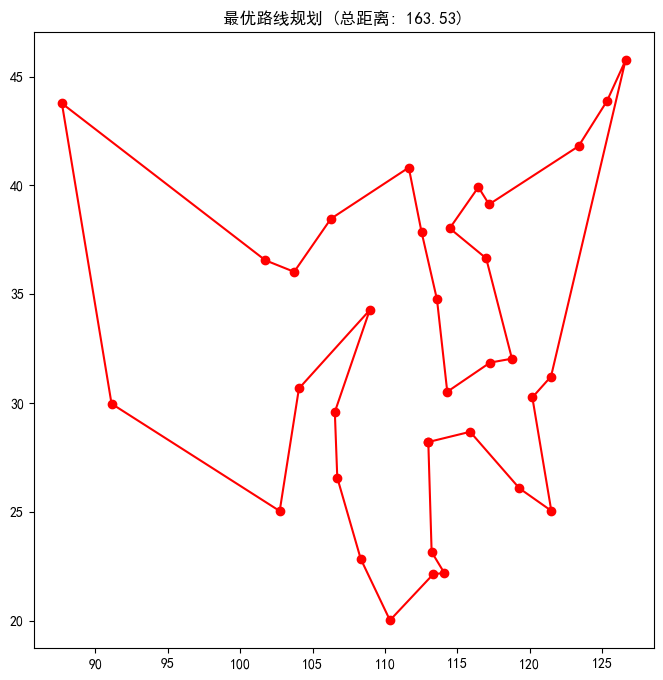

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax.set_title(f'最优路线规划 (总距离: {best_distance[0]:.2f})')
ax.plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
plt.show()


## 实验 二
● 内容描述：
你将扮演一位试图找到复杂地形“最低谷”的探险家。你将使用模拟“鸟群觅食”行为的粒子群算法（PSO），在给定的数学函数（地形图）上，智能地搜索其全局最小值点。

● 实验要求与操作步骤：

- 步骤一：通过交互式动画建立直观理解

- 在编写代码之前，请先打开老师提供的 pso_demo.html 文件。这是一个粒子群算法的动态演示。请尝试拖动 w (惯性权重), c1 (自我认知), c2 (社会经验) 的滑块，并观察图中“焦点粒子”（红色）身上的彩色箭头如何变化。思考这些参数是如何影响粒子飞行的。

- 步骤二：运行代码并进行参数探索

在理解了参数的直观作用后，我们将在Python代码中验证我们的观察。请先运行以下完整代码，然后根据思考题的指引进行参数调整。

 思考题：

- 【探索惯性权重】 结合 pso_demo.html 中的观察，描述参数 w (惯性权重) 的作用。在Python代码中，分别设置一个较大的 w (如 1.1) 和一个较小的 w (如 0.4)，运行后观察收敛曲线图有何不同？哪种情况收敛更快？哪种情况的最终结果可能更好（更接近理论最小值0）？

- 【探索学习因子】 同样地，结合HTML动画，描述 c1 (自我认知) 和 c2 (社会经验) 的作用。请设计一组实验（例如，一组 c1=2.0, c2=0.1，另一组 c1=0.1, c2=2.0），在Python代码中运行并观察结果。这两种“极端”的设置分别对粒子群的搜索行为（收敛速度、最终结果）造成了什么影响？

--- 正在绘制目标函数的三维图像 ---


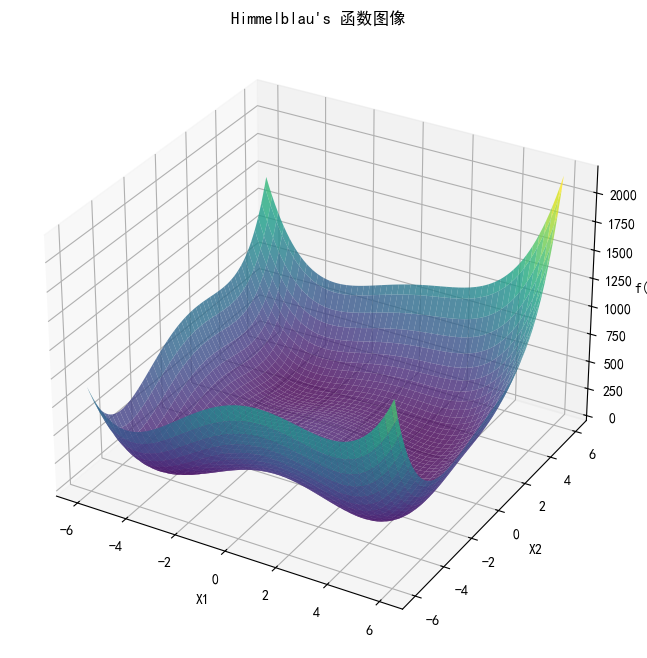


--- 开始运行粒子群算法求解函数极值 ---


In [ ]:
# 导入需要的库
from sko.PSO import PSO    #sko.PSO模块是scikit-opt库中实现粒子群优化算法的核心组件
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D   #导入 Matplotlib 库中 3D 绘图功能

# --- 1. 定义一个通用的二元函数绘图方法 (代码已完成) ---
def plot_2d_function(func, x_range=(-6, 6), y_range=(-6, 6), title="函数图像"):    #x,y轴范围-6~6
    x = np.linspace(x_range[0], x_range[1], 100)   #生成100个等间距的点，作为x坐标
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)   #将x和y坐标网格化，生成两个二维数组X和Y，分别代表网格点的x坐标和y坐标。
    Z = np.zeros_like(X)       #创建一个与X形状相同的二维数组Z，并初始化为0，用于存储函数值。
    #双重循环遍历网格中的每一个点，计算函数在该点(X[i,j], Y[i,j])处的值，并存入Z数组的对应位置。
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func([X[i, j], Y[i, j]])
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')    #在图形中添加一个3D子图。参数111表示1行1列的第1个子图
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)   #绘制3D曲面图，使用X和Y作为网格坐标，Z为高度.cmap='viridis': 使用viridis颜色映射。edgecolor='none': 不显示网格线,alpha=0.8: 设置透明度为0.8。
    ax.set_title(title)
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('f(x)')
    plt.show()

# --- 2. 定义目标函数 (代码已完成) ---
def objective_function(x):
    x1, x2 = x
    # Himmelblau's函数，它有4个相同的最小值点
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

# --- 3. 可视化目标函数 (代码已完成) ---
print("--- 正在绘制目标函数的三维图像 ---")
plot_2d_function(objective_function, title="Himmelblau's 函数图像")

# --- 4. 配置并运行粒子群算法 ---
print("\n--- 开始运行粒子群算法求解函数极值 ---")

-  <font color='red'>核心操作区域：请在下面的cell里修改参数以进行实验</font>

In [ ]:
# 参数提示: func=适应度函数, dim=维度, pop=种群大小, max_iter=最大迭代次数, lb,ub搜索空间的上下边界，w 惯性权重, c1 自我认知, c2 社会经验
pso = PSO(func=objective_function, dim=2, pop=50, max_iter=150, lb=[-6, -6], ub=[6, 6], w=0.8, c1=0.2, c2=2.0)

最优位置: [3.08400097 1.93269107]
最小函数值: [0.22957079]


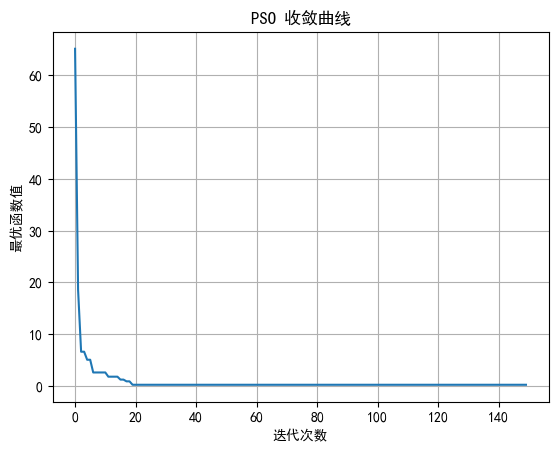

In [ ]:
# 运行算法，然后从对象属性中获取结果
pso.run()
best_position = pso.gbest_x
best_value = pso.gbest_y

print('最优位置:', best_position)
print('最小函数值:', best_value)

# --- 5. 可视化收敛过程 (代码已完成) ---
plt.figure()
plt.title("PSO 收敛曲线")
plt.xlabel("迭代次数")
plt.ylabel("最优函数值")
plt.plot(pso.gbest_y_hist)   #绘制收敛曲线的折线图，pso.gbest_y_hist：PSO算法中记录的全局最优适应度值的历史列表
plt.grid(True)          #添加网格线
plt.show()


最优位置: [-3.77931025 -3.28318599]
最小函数值: [7.88860905e-31]


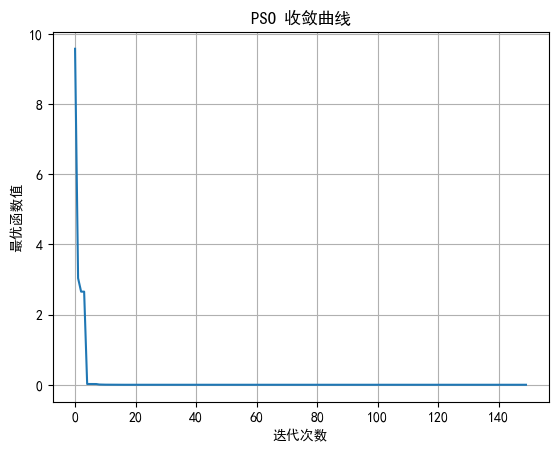

In [ ]:
# 运行算法，然后从对象属性中获取结果
pso.run()
best_position = pso.gbest_x
best_value = pso.gbest_y

print('最优位置:', best_position)
print('最小函数值:', best_value)

# --- 5. 可视化收敛过程 (代码已完成) ---
plt.figure()
plt.title("PSO 收敛曲线")
plt.xlabel("迭代次数")
plt.ylabel("最优函数值")
plt.plot(pso.gbest_y_hist)   
plt.grid(True)          
plt.show()


最优位置: [ 3.58442854 -1.84812751]
最小函数值: [1.47140447e-11]


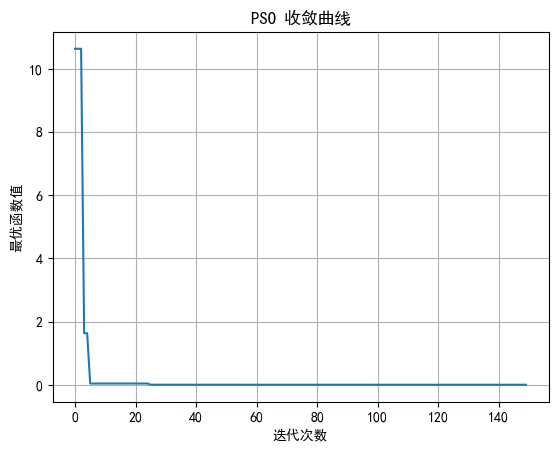

In [ ]:
# 运行算法，然后从对象属性中获取结果
pso.run()
best_position = pso.gbest_x
best_value = pso.gbest_y

print('最优位置:', best_position)
print('最小函数值:', best_value)

# --- 5. 可视化收敛过程 (代码已完成) ---
plt.figure()
plt.title("PSO 收敛曲线")
plt.xlabel("迭代次数")
plt.ylabel("最优函数值")
plt.plot(pso.gbest_y_hist)   #
plt.grid(True)          #
plt.show()


最优位置: [ 3.58443044 -1.84813324]
最小函数值: [7.94559755e-10]


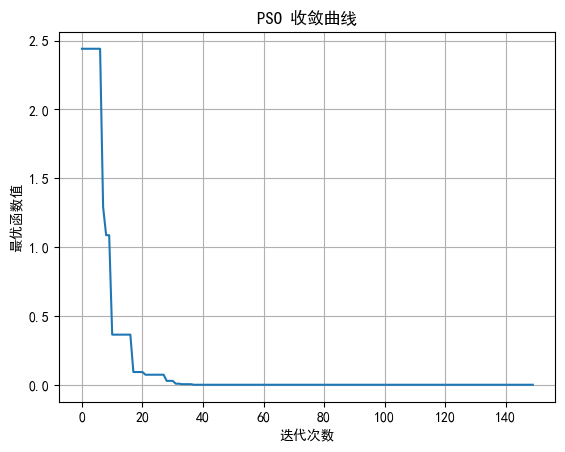

In [ ]:
# 运行算法，然后从对象属性中获取结果
pso.run()
best_position = pso.gbest_x
best_value = pso.gbest_y

print('最优位置:', best_position)
print('最小函数值:', best_value)

# --- 5. 可视化收敛过程 (代码已完成) ---
plt.figure()
plt.title("PSO 收敛曲线")
plt.xlabel("迭代次数")
plt.ylabel("最优函数值")
plt.plot(pso.gbest_y_hist)   #
plt.grid(True)          #
plt.show()